In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import CoxPHFitter, KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lifelines.utils import concordance_index
from metric import score
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from scipy.stats import rankdata

In [3]:
train_path = "data/train.csv"
test_path = "data/test.csv"
sample_path = "data/sample_submission.csv"
data_dict_path = "data/data_dictionary.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
data_dict_df = pd.read_csv(data_dict_path)

In [4]:
RMV = ["ID", "efs", "efs_time", "y"]
FEATURES = [c for c in train_df.columns if not c in RMV]
print(f"Total features: {len(FEATURES)} - {FEATURES}")

Total features: 57 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'hla_match_c_high', 'hla_high_res_8', 'tbi_status', 'arrhythmia', 'hla_low_res_6', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'hla_high_res_6', 'cmv_status', 'hla_high_res_10', 'hla_match_dqb1_high', 'tce_imm_match', 'hla_nmdp_6', 'hla_match_c_low', 'rituximab', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'year_hct', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hla_match_a_high', 'hepatic_severe', 'donor_age', 'prior_tumor', 'hla_match_b_low', 'peptic_ulcer', 'age_at_hct', 'hla_match_a_low', 'gvhd_proph', 'rheum_issue', 'sex_match', 'hla_match_b_high', 'race_group', 'comorbidity_score', 'karnofsky_score', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'hla_low_res_8', 'cardiac', 'hla_match_drb1_high', 'pulm_moderate', 'hla_low_res_10']


In [5]:
CAT_FEATURES = []
for f in FEATURES:
    if train_df[f].dtype == "object":
        CAT_FEATURES.append(f)
        train_df[f] = train_df[f].fillna("NAN")
        test_df[f] = test_df[f].fillna("NAN")

print(f"Categorical features: {len(CAT_FEATURES)} - {CAT_FEATURES}")

Categorical features: 35 - ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab', 'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate']


In [6]:
CAT_SIZE = []
CAT_EMB = []
NUMS = []

combined = pd.concat([train_df,test_df],axis=0,ignore_index=True)
#print("Combined data shape:", combined.shape )

print("We LABEL ENCODE the CATEGORICAL FEATURES: ")

for c in FEATURES:
    if c in CAT_FEATURES:
        # LABEL ENCODE
        combined[c],_ = combined[c].factorize()
        combined[c] -= combined[c].min()
        combined[c] = combined[c].astype("int32")
        #combined[c] = combined[c].astype("category")

        n = combined[c].nunique()
        mn = combined[c].min()
        mx = combined[c].max()
        print(f'{c} has ({n}) unique values')

        CAT_SIZE.append(mx+1) 
        CAT_EMB.append( int(np.ceil( np.sqrt(mx+1))) ) 
    else:
        if combined[c].dtype=="float64":
            combined[c] = combined[c].astype("float32")
        if combined[c].dtype=="int64":
            combined[c] = combined[c].astype("int32")
            
        m = combined[c].mean()
        s = combined[c].std()
        combined[c] = (combined[c]-m)/s
        combined[c] = combined[c].fillna(0)
        
        NUMS.append(c)
        
train = combined.iloc[:len(train_df)].copy()
test = combined.iloc[len(train_df):].reset_index(drop=True).copy()

We LABEL ENCODE the CATEGORICAL FEATURES: 
dri_score has (12) unique values
psych_disturb has (4) unique values
cyto_score has (8) unique values
diabetes has (4) unique values
tbi_status has (8) unique values
arrhythmia has (4) unique values
graft_type has (2) unique values
vent_hist has (3) unique values
renal_issue has (4) unique values
pulm_severe has (4) unique values
prim_disease_hct has (18) unique values
cmv_status has (5) unique values
tce_imm_match has (9) unique values
rituximab has (3) unique values
prod_type has (2) unique values
cyto_score_detail has (6) unique values
conditioning_intensity has (7) unique values
ethnicity has (4) unique values
obesity has (4) unique values
mrd_hct has (3) unique values
in_vivo_tcd has (3) unique values
tce_match has (5) unique values
hepatic_severe has (4) unique values
prior_tumor has (4) unique values
peptic_ulcer has (4) unique values
gvhd_proph has (18) unique values
rheum_issue has (4) unique values
sex_match has (5) unique values
rac

In [10]:
train["y"] = transform_survival_probability(train, time_col='efs_time', event_col='efs')

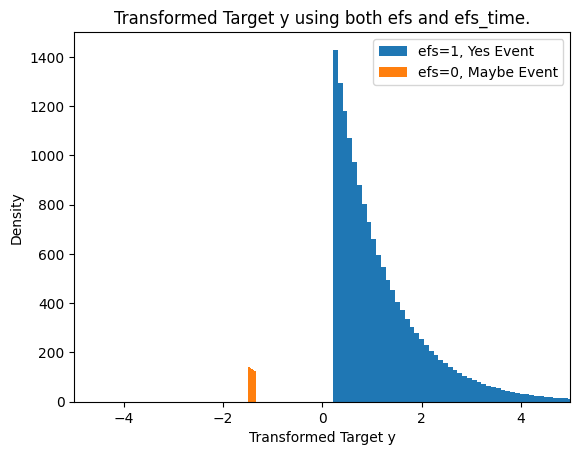

In [7]:
train["y"] = train.efs_time.values
mx = train.loc[train.efs==1,"efs_time"].max()
mn = train.loc[train.efs==0,"efs_time"].min()
train.loc[train.efs==0,"y"] = train.loc[train.efs==0,"y"] + mx - mn
train.y = train.y.rank()
train.loc[train.efs==0,"y"] += 2*len(train)
train.y = train.y / train.y.max()
train.y = np.log( train.y )
train.y -= train.y.mean()
train.y *= -1.0

plt.hist(train.loc[train.efs==1,"y"],bins=100,label="efs=1, Yes Event")
plt.hist(train.loc[train.efs==0,"y"],bins=100,label="efs=0, Maybe Event")
plt.xlim((-5,5))
plt.xlabel("Transformed Target y")
plt.ylabel("Density")
plt.title("Transformed Target y using both efs and efs_time.")
plt.legend()
plt.show()

In [8]:
from pytorch_tabnet.tab_model import TabNetRegressor

In [12]:
X = train.drop(columns=RMV).copy().values
y = train[["y"]].copy().values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

model = TabNetRegressor()

# Train the Model
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=['rmse'],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.21265 | val_0_rmse: 1.45787 |  0:00:05s
epoch 1  | loss: 2.11491 | val_0_rmse: 1.44195 |  0:00:09s
epoch 2  | loss: 2.08999 | val_0_rmse: 1.44651 |  0:00:13s
epoch 3  | loss: 2.08605 | val_0_rmse: 1.44083 |  0:00:19s
epoch 4  | loss: 2.06313 | val_0_rmse: 1.45227 |  0:00:24s
epoch 5  | loss: 2.06358 | val_0_rmse: 1.44207 |  0:00:28s
epoch 6  | loss: 2.05502 | val_0_rmse: 1.4339  |  0:00:33s
epoch 7  | loss: 2.04661 | val_0_rmse: 1.43467 |  0:00:37s
epoch 8  | loss: 2.03669 | val_0_rmse: 1.42912 |  0:00:41s
epoch 9  | loss: 2.0444  | val_0_rmse: 1.42588 |  0:00:45s
epoch 10 | loss: 2.02844 | val_0_rmse: 1.42608 |  0:00:50s
epoch 11 | loss: 2.01785 | val_0_rmse: 1.42515 |  0:00:54s
epoch 12 | loss: 2.01011 | val_0_rmse: 1.42546 |  0:00:58s
epoch 13 | loss: 2.0052  | val_0_rmse: 1.4165  |  0:01:03s
epoch 14 | loss: 2.00084 | val_0_rmse: 1.4247  |  0:01:07s
epoch 15 | loss: 2.01086 | val_0_rmse: 1.42456 |  0:01:12s
epoch 16 | loss: 2.01178 | val_0_rmse: 1.41665 |  0:01:1

C:\Users\tkvkh\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [16]:
prediction = model.predict(X_valid)
X = train.copy()
y = train[["y"]].copy()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

y_true = X_valid[["ID","efs","efs_time","race_group"]].copy()
y_pred = X_valid[["ID"]].copy()
y_pred["prediction"] = prediction
m = score(y_true.copy(), y_pred.copy(), "ID")
print(f"Overall CV for NN =",m)

KeyError: 0